# Fetch Rewards Data Analysis

In [1]:
# imports
import pandas as pd
import json
import csv
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
!pip install chart_studio
import chart_studio.plotly as py 
import plotly.graph_objs as go #importing graphical objects
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

     |████████████████████████████████| 71kB 1.5MB/s eta 0:00:01


# Read Json Data apply transformation to store in sql database

In [2]:
# read input file

def read_file (filename):
    temp_list = []
    with open(filename) as file:
        lines = file.readlines()
    for line in lines:
        temp_list.append(json.loads(line))
    return temp_list

In [3]:
## generate brand list

def transform_brands(brands):
    for i in brands:
        i['_id'] = i['_id']['$oid'] if '_id' in i and '$oid' in i['_id'] else None
        i['cpg_id'] = i['cpg']['$id']['$oid'] if 'cpg' in i and '$id' in i['cpg'] and '$oid' in i['cpg']['$id'] else None
        i['cpg_ref'] = i['cpg']['$ref'] if 'cpg' in i and '$ref' in i['cpg'] else None
    return brands

In [4]:
## generate user list

def transform_users(users):
    for i in users:
        i['_id'] = i['_id']['$oid'] if '_id' in i and '$oid' in i['_id'] else None
        i['createdDate'] = datetime.fromtimestamp((i['createdDate']['$date'])/1000.0) if 'createdDate' in i and '$date' in i['createdDate'] else None
        i['lastLogin'] = datetime.fromtimestamp((i['lastLogin']['$date'])/1000.0) if 'lastLogin' in i and '$date' in i['lastLogin'] else None
    return users

In [5]:
## generate receipt list

def transform_receipts(receipts):
    rewardsReceiptItemList = []
    for i in receipts:
        if 'rewardsReceiptItemList' in i:
            for j in i['rewardsReceiptItemList']:
                j['receiptid'] = i['_id']['$oid']
                rewardsReceiptItemList.append(j)
    
    for i in receipts:
        i['_id'] = i['_id']['$oid'] if '_id' in i and '$oid' in i['_id'] else None
        i['createDate'] = datetime.fromtimestamp((i['createDate']['$date'])/1000.0) if 'createDate' in i and '$date' in i['createDate'] else None
        i['dateScanned'] = datetime.fromtimestamp((i['dateScanned']['$date'])/1000.0) if 'dateScanned' in i and '$date' in i['dateScanned'] else None
        i['finishedDate'] = datetime.fromtimestamp((i['finishedDate']['$date'])/1000.0) if 'finishedDate' in i and '$date' in i['finishedDate'] else None
        i['modifyDate'] = datetime.fromtimestamp((i['modifyDate']['$date'])/1000.0) if 'modifyDate' in i and '$date' in i['modifyDate'] else None
        i['pointsAwardedDate'] = datetime.fromtimestamp((i['pointsAwardedDate']['$date'])/1000.0) if 'pointsAwardedDate' in i and '$date' in i['pointsAwardedDate'] else None
        i['purchaseDate'] = datetime.fromtimestamp((i['purchaseDate']['$date'])/1000.0) if 'purchaseDate' in i and '$date' in i['purchaseDate'] else None
    
    return receipts, rewardsReceiptItemList

In [6]:
# write file to CSV

def writeToCSV(filename, data):
    keys = set().union(*(d.keys() for d in data))
    with open(filename, 'w', newline='')  as output_file:
        dict_writer = csv.DictWriter(output_file, keys)
        dict_writer.writeheader()
        dict_writer.writerows(data)

In [8]:
# Read and Write file

filenames = ['../receipts.json']

receipts_list = read_file('../receipts.json')
brands_list = read_file('../brands.json')
users_list = read_file('../users.json')

receipt_list, rewardsReceiptItemList = transform_receipts(receipts_list)
brand_list = transform_brands(brands_list)
user_list = transform_users(users_list)

writeToCSV('receipts.csv', receipt_list)
writeToCSV('rewardsReceiptItemList.csv',rewardsReceiptItemList)
writeToCSV('brands.csv',brand_list)
writeToCSV('users.csv',user_list)

# Third: Evaluate Data Quality Issues in the Data Provided

## Data Exploration

In [9]:
# Read Users Data

df = pd.read_csv('users.csv')
df_user = pd.DataFrame(df)
df_user['createdDate']=pd.to_datetime(df_user['createdDate'], unit='ns')
df_user['lastLogin']=pd.to_datetime(df_user['lastLogin'], unit='ns')
df_user.head()

,role,signUpSource,createdDate,_id,state,lastLogin,active
0,consumer,Email,2021-01-03 10:24:04.800,5ff1e194b6a9d73a3a9f1052,WI,2021-01-03 10:25:37.858,True
1,consumer,Email,2021-01-03 10:24:04.800,5ff1e194b6a9d73a3a9f1052,WI,2021-01-03 10:25:37.858,True
2,consumer,Email,2021-01-03 10:24:04.800,5ff1e194b6a9d73a3a9f1052,WI,2021-01-03 10:25:37.858,True
3,consumer,Email,2021-01-03 10:25:30.554,5ff1e1eacfcf6c399c274ae6,WI,2021-01-03 10:25:30.597,True
4,consumer,Email,2021-01-03 10:24:04.800,5ff1e194b6a9d73a3a9f1052,WI,2021-01-03 10:25:37.858,True


In [10]:
# Checking the datatypes

df_user.dtypes

role                    object
signUpSource            object
createdDate     datetime64[ns]
_id                     object
state                   object
lastLogin       datetime64[ns]
active                    bool
dtype: object

In [11]:
# check null values 

df_user.isnull().sum()

role             0
signUpSource    48
createdDate      0
_id              0
state           56
lastLogin       62
active           0
dtype: int64

### From the above null check, we found that state, lastLogin and signUpSource have lot of null values. Nearly 

### 5% of data is missing and these fields seems useful in data analysis thus, we can either use different null 

### imputation methods to fill in the missing values or we can put mandatory field value required checks to avoid missing data.   

In [12]:
# Check duplicates 

pd.concat(g for _, g in df_user.groupby("_id") if len(g) > 1)


,role,signUpSource,createdDate,_id,state,lastLogin,active
475,fetch-staff,NaN,2014-12-19 09:21:22.381,54943462e4b07e684157a532,NaN,2021-03-05 11:52:23.204,True
476,fetch-staff,NaN,2014-12-19 09:21:22.381,54943462e4b07e684157a532,NaN,2021-03-05 11:52:23.204,True
477,fetch-staff,NaN,2014-12-19 09:21:22.381,54943462e4b07e684157a532,NaN,2021-03-05 11:52:23.204,True
478,fetch-staff,NaN,2014-12-19 09:21:22.381,54943462e4b07e684157a532,NaN,2021-03-05 11:52:23.204,True
479,fetch-staff,NaN,2014-12-19 09:21:22.381,54943462e4b07e684157a532,NaN,2021-03-05 11:52:23.204,True
...,...,...,...,...,...,...,...
374,consumer,Email,2021-02-01 19:28:04.020,60189c94c8b50e11d8454f6b,WI,2021-02-01 19:28:04.073,True
385,consumer,Email,2021-02-04 12:16:53.700,601c2c05969c0b11f7d0b097,WI,2021-02-04 12:20:30.228,True
387,consumer,Email,2021-02-04 12:16:53.700,601c2c05969c0b11f7d0b097,WI,2021-02-04 12:20:30.228,True
393,consumer,Email,2021-02-09 09:17:52.581,60229990b57b8a12187fe9e0,WI,2021-02-09 09:17:52.626,True


In [13]:
print("Total number of duplicate users are:",df_user['_id'].duplicated().sum())

Total number of duplicate users are: 283


In [14]:
print("Total number of unique users are:", len(df_user['_id'].unique()))

Total number of unique users are: 212


In [15]:
print("Total number of Users are:", df_user.shape[0])

Total number of Users are: 495


### There are duplicates in user table, user_id is repated for multiple times. Around 283 user_ids are duplicated having only 212 unique values outof 495 total records, Thus user_id cannot be considered as Primary Key

In [16]:
# Read brands data 

df = pd.read_csv('brands.csv')
df_brands = pd.DataFrame(df)
df_brands.head()

,name,cpg,brandCode,category,topBrand,categoryCode,_id,barcode,cpg_ref,cpg_id
0,test brand @1612366101024,"{'$id': {'$oid': '601ac114be37ce2ead437550'}, ...",NaN,Baking,False,BAKING,601ac115be37ce2ead437551,511111019862,Cogs,601ac114be37ce2ead437550
1,Starbucks,"{'$id': {'$oid': '5332f5fbe4b03c9a25efd0ba'}, ...",STARBUCKS,Beverages,False,BEVERAGES,601c5460be37ce2ead43755f,511111519928,Cogs,5332f5fbe4b03c9a25efd0ba
2,test brand @1612366146176,"{'$id': {'$oid': '601ac142be37ce2ead437559'}, ...",TEST BRANDCODE @1612366146176,Baking,False,BAKING,601ac142be37ce2ead43755d,511111819905,Cogs,601ac142be37ce2ead437559
3,test brand @1612366146051,"{'$id': {'$oid': '601ac142be37ce2ead437559'}, ...",TEST BRANDCODE @1612366146051,Baking,False,BAKING,601ac142be37ce2ead43755a,511111519874,Cogs,601ac142be37ce2ead437559
4,test brand @1612366146827,"{'$id': {'$oid': '5332fa12e4b03c9a25efd1e7'}, ...",TEST BRANDCODE @1612366146827,Candy & Sweets,False,CANDY_AND_SWEETS,601ac142be37ce2ead43755e,511111319917,Cogs,5332fa12e4b03c9a25efd1e7


In [17]:
# Checking data types

df_brands.dtypes

name            object
cpg             object
brandCode       object
category        object
topBrand        object
categoryCode    object
_id             object
barcode          int64
cpg_ref         object
cpg_id          object
dtype: object

In [18]:
# check null values 

df_brands.isnull().sum()

name              0
cpg               0
brandCode       269
category        155
topBrand        612
categoryCode    650
_id               0
barcode           0
cpg_ref           0
cpg_id            0
dtype: int64

In [19]:
df_brands.shape[0]

1167

### 6% of null values are present in brands table. 

In [20]:
# Check duplicates 

df_brands.duplicated().sum()

0

In [21]:
# Check category types

df_brands['category'].value_counts()

Baking                         369
Beer Wine Spirits               90
Snacks                          75
Candy & Sweets                  71
Beverages                       63
Magazines                       44
Health & Wellness               44
Breakfast & Cereal              40
Grocery                         39
Dairy                           33
Condiments & Sauces             27
Frozen                          24
Personal Care                   20
Baby                            18
Canned Goods & Soups            12
Beauty                           9
Beauty & Personal Care           6
Cleaning & Home Improvement      6
Deli                             6
Dairy & Refrigerated             5
Bread & Bakery                   5
Household                        5
Outdoor                          1
Name: category, dtype: int64

In [22]:
# Read receipts data

df = pd.read_csv('receipts.csv')
df_receipts = pd.DataFrame(df)
df_receipts

,purchaseDate,pointsEarned,bonusPointsEarnedReason,userId,rewardsReceiptItemList,finishedDate,modifyDate,purchasedItemCount,_id,createDate,bonusPointsEarned,pointsAwardedDate,rewardsReceiptStatus,totalSpent,dateScanned
0,2021-01-02 19:00:00,500.0,"Receipt number 2 completed, bonus point schedu...",5ff1e1eacfcf6c399c274ae6,"[{'barcode': '4011', 'description': 'ITEM NOT ...",2021-01-03 10:25:31,2021-01-03 10:25:36,5.0,5ff1e1eb0a720f0523000575,2021-01-03 10:25:31,500.0,2021-01-03 10:25:31,FINISHED,26.00,2021-01-03 10:25:31
1,2021-01-02 10:24:43,150.0,"Receipt number 5 completed, bonus point schedu...",5ff1e194b6a9d73a3a9f1052,"[{'barcode': '4011', 'description': 'ITEM NOT ...",2021-01-03 10:24:43,2021-01-03 10:24:48,2.0,5ff1e1bb0a720f052300056b,2021-01-03 10:24:43,150.0,2021-01-03 10:24:43,FINISHED,11.00,2021-01-03 10:24:43
2,2021-01-02 19:00:00,5.0,All-receipts receipt bonus,5ff1e1f1cfcf6c399c274b0b,"[{'needsFetchReview': False, 'partnerItemId': ...",NaN,2021-01-03 10:25:42,1.0,5ff1e1f10a720f052300057a,2021-01-03 10:25:37,5.0,NaN,REJECTED,10.00,2021-01-03 10:25:37
3,2021-01-02 19:00:00,5.0,All-receipts receipt bonus,5ff1e1eacfcf6c399c274ae6,"[{'barcode': '4011', 'description': 'ITEM NOT ...",2021-01-03 10:25:34,2021-01-03 10:25:39,4.0,5ff1e1ee0a7214ada100056f,2021-01-03 10:25:34,5.0,2021-01-03 10:25:34,FINISHED,28.00,2021-01-03 10:25:34
4,2021-01-02 10:25:06,5.0,All-receipts receipt bonus,5ff1e194b6a9d73a3a9f1052,"[{'barcode': '4011', 'description': 'ITEM NOT ...",2021-01-03 10:25:11,2021-01-03 10:25:11,2.0,5ff1e1d20a7214ada1000561,2021-01-03 10:25:06,5.0,2021-01-03 10:25:06,FINISHED,1.00,2021-01-03 10:25:06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1114,2020-08-16 20:00:00,25.0,COMPLETE_NONPARTNER_RECEIPT,5fc961c3b8cfca11a077dd33,"[{'barcode': 'B076FJ92M4', 'description': 'mue...",NaN,2021-03-01 05:22:28,2.0,603cc0630a720fde100003e6,2021-03-01 05:22:27,25.0,NaN,REJECTED,34.96,2021-03-01 05:22:27
1115,NaN,NaN,NaN,5fc961c3b8cfca11a077dd33,NaN,NaN,2021-03-01 10:42:41.873000,NaN,603d0b710a720fde1000042a,2021-03-01 10:42:41.873000,NaN,NaN,SUBMITTED,NaN,2021-03-01 10:42:41.873000
1116,NaN,NaN,NaN,5fc961c3b8cfca11a077dd33,NaN,NaN,2021-03-01 09:07:37.664000,NaN,603cf5290a720fde10000413,2021-03-01 09:07:37.664000,NaN,NaN,SUBMITTED,NaN,2021-03-01 09:07:37.664000
1117,2020-08-16 20:00:00,25.0,COMPLETE_NONPARTNER_RECEIPT,5fc961c3b8cfca11a077dd33,"[{'barcode': 'B076FJ92M4', 'description': 'mue...",NaN,2021-03-01 08:07:29,2.0,603ce7100a7217c72c000405,2021-03-01 08:07:28,25.0,NaN,REJECTED,34.96,2021-03-01 08:07:28


In [23]:
# Check Null values in Receipt table

df_receipts.isnull().sum()

purchaseDate               448
pointsEarned               510
bonusPointsEarnedReason    575
userId                       0
rewardsReceiptItemList     440
finishedDate               551
modifyDate                   0
purchasedItemCount         484
_id                          0
createDate                   0
bonusPointsEarned          575
pointsAwardedDate          582
rewardsReceiptStatus         0
totalSpent                 435
dateScanned                  0
dtype: int64

In [24]:
# Formating dates in a particular datetime format

df_receipts['createDate']=pd.to_datetime(df_receipts['createDate'], unit='ns')
df_receipts['dateScanned']=pd.to_datetime(df_receipts['dateScanned'], unit='ns')
df_receipts['finishedDate']=pd.to_datetime(df_receipts['finishedDate'], unit='ns')
df_receipts['modifyDate']=pd.to_datetime(df_receipts['modifyDate'], unit='ns')
df_receipts['pointsAwardedDate']=pd.to_datetime(df_receipts['pointsAwardedDate'], unit='ns')
df_receipts['purchaseDate']=pd.to_datetime(df_receipts['purchaseDate'], unit='ns')

In [25]:
df_receipts.dtypes

purchaseDate               datetime64[ns]
pointsEarned                      float64
bonusPointsEarnedReason            object
userId                             object
rewardsReceiptItemList             object
finishedDate               datetime64[ns]
modifyDate                 datetime64[ns]
purchasedItemCount                float64
_id                                object
createDate                 datetime64[ns]
bonusPointsEarned                 float64
pointsAwardedDate          datetime64[ns]
rewardsReceiptStatus               object
totalSpent                        float64
dateScanned                datetime64[ns]
dtype: object

In [26]:
df_receipts.describe()

,pointsEarned,purchasedItemCount,bonusPointsEarned,totalSpent
count,609.000000,635.00000,544.000000,684.000000
mean,585.962890,14.75748,238.893382,77.796857
std,1357.166947,61.13424,299.091731,347.110349
min,0.000000,0.00000,5.000000,0.000000
25%,5.000000,1.00000,5.000000,1.000000
50%,150.000000,2.00000,45.000000,18.200000
75%,750.000000,5.00000,500.000000,34.960000
max,10199.800000,689.00000,750.000000,4721.950000


In [27]:
df_receipts[(df_receipts['rewardsReceiptStatus'] == 'FINISHED') & (df_receipts['purchasedItemCount']== 0)]

,purchaseDate,pointsEarned,bonusPointsEarnedReason,userId,rewardsReceiptItemList,finishedDate,modifyDate,purchasedItemCount,_id,createDate,bonusPointsEarned,pointsAwardedDate,rewardsReceiptStatus,totalSpent,dateScanned
396,2021-01-20 19:00:00,250.0,"Receipt number 3 completed, bonus point schedu...",6009e60450b3311194385009,NaN,2021-01-21 15:59:06,2021-01-21 15:59:15,0.0,6009eb000a7214ada2000003,2021-01-21 15:58:40,250.0,2021-01-21 15:59:06,FINISHED,0.0,2021-01-21 15:58:40
424,2021-01-21 19:00:00,500.0,"Receipt number 2 completed, bonus point schedu...",600afb2a7d983a124e9aded0,NaN,2021-01-22 11:37:01,2021-01-22 11:37:13,0.0,600aff160a720f053500000c,2021-01-22 11:36:38,500.0,2021-01-22 11:37:01,FINISHED,0.0,2021-01-22 11:36:38


### Here, the rewardsReceiptStatus is in FINISHED state but purchasedItemCount is 0 also bonusPoints are earned for the particular receipt. 

In [28]:
df = pd.read_csv('rewardsReceiptItemList.csv')
df_r_itemList = pd.DataFrame(df)
df_r_itemList

,itemPrice,priceAfterCoupon,pointsPayerId,rewardsProductPartnerId,rewardsGroup,receiptid,targetPrice,needsFetchReviewReason,metabriteCampaignId,barcode,...,pointsEarned,deleted,finalPrice,originalMetaBriteDescription,competitiveProduct,userFlaggedQuantity,preventTargetGapPoints,partnerItemId,originalMetaBriteItemPrice,originalMetaBriteBarcode
0,26.00,NaN,NaN,NaN,NaN,5ff1e1eb0a720f0523000575,NaN,NaN,NaN,4011,...,NaN,NaN,26.00,NaN,NaN,5.0,True,1,NaN,NaN
1,1.00,NaN,NaN,NaN,NaN,5ff1e1bb0a720f052300056b,NaN,NaN,NaN,4011,...,NaN,NaN,1.00,NaN,NaN,NaN,NaN,1,NaN,NaN
2,10.00,NaN,5332f5fbe4b03c9a25efd0ba,5332f5fbe4b03c9a25efd0ba,DORITOS SPICY SWEET CHILI SINGLE SERVE,5ff1e1bb0a720f052300056b,NaN,USER_FLAGGED,NaN,028400642255,...,NaN,NaN,10.00,NaN,NaN,1.0,True,2,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,5ff1e1f10a720f052300057a,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,3.0,True,1,NaN,NaN
4,28.00,NaN,NaN,NaN,NaN,5ff1e1ee0a7214ada100056f,NaN,NaN,NaN,4011,...,NaN,NaN,28.00,NaN,NaN,4.0,True,1,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6936,11.99,11.99,NaN,NaN,NaN,603cc2bc0a720fde100003e9,NaN,NaN,NaN,B07BRRLSVC,...,NaN,NaN,11.99,NaN,NaN,NaN,NaN,1,NaN,NaN
6937,22.97,22.97,NaN,NaN,NaN,603cc0630a720fde100003e6,NaN,NaN,NaN,B076FJ92M4,...,NaN,NaN,22.97,NaN,NaN,NaN,NaN,0,NaN,NaN
6938,11.99,11.99,NaN,NaN,NaN,603cc0630a720fde100003e6,NaN,NaN,NaN,B07BRRLSVC,...,NaN,NaN,11.99,NaN,NaN,NaN,NaN,1,NaN,NaN
6939,22.97,22.97,NaN,NaN,NaN,603ce7100a7217c72c000405,NaN,NaN,NaN,B076FJ92M4,...,NaN,NaN,22.97,NaN,NaN,NaN,NaN,0,NaN,NaN


In [29]:
print(df_r_itemList.shape[0])
print(len(df_r_itemList['barcode'].unique()))

6941
569


In [30]:
df_r_itemList.isnull().sum()

itemPrice                              174
priceAfterCoupon                      5985
pointsPayerId                         5674
rewardsProductPartnerId               4672
rewardsGroup                          5210
receiptid                                0
targetPrice                           6563
needsFetchReviewReason                6722
metabriteCampaignId                   6078
barcode                               3851
userFlaggedPrice                      6642
discountedItemPrice                   1172
userFlaggedBarcode                    6604
competitorRewardsGroup                6666
originalReceiptItemText               1181
originalFinalPrice                    6932
brandCode                             4341
quantityPurchased                      174
itemNumber                            6788
userFlaggedDescription                6787
pointsNotAwardedReason                6601
description                            381
userFlaggedNewItem                    6618
needsFetchR

In [31]:
df_r_itemList.dtypes

itemPrice                             float64
priceAfterCoupon                      float64
pointsPayerId                          object
rewardsProductPartnerId                object
rewardsGroup                           object
receiptid                              object
targetPrice                           float64
needsFetchReviewReason                 object
metabriteCampaignId                    object
barcode                                object
userFlaggedPrice                      float64
discountedItemPrice                   float64
userFlaggedBarcode                    float64
competitorRewardsGroup                 object
originalReceiptItemText                object
originalFinalPrice                    float64
brandCode                              object
quantityPurchased                     float64
itemNumber                            float64
userFlaggedDescription                 object
pointsNotAwardedReason                 object
description                       

In [32]:
df_r_itemList['receiptid'].duplicated().sum()

6262

## Data Quality Issues

#### 1. From the above analysis, we found that lot of NULL data is present in the Users, Receipts, ReceiptItemList and Brands table.

#### 2. Duplicate values are present for User_id, Thus we cannot keep user_id as a primary key in the Users table as it is not unique

#### 3. Date Format is not present in Date atrributes 

## Visualization Plots

### Active Users in USA

In [33]:
df_user['user_count'] = df_user['_id'].groupby(df_user['state']).transform('count')

In [34]:
data = dict(type='choropleth',
            locations = df_user['state'],
            locationmode = 'USA-states',
            colorscale = 'Reds',
            text = df_user['active'],
            z = df_user['user_count'],
            colorbar = {'title':"Active User Count"}
            )

In [35]:
layout = dict(title = 'Active Users in USA Map',
              geo = dict(scope='usa')
             )

In [39]:
choromap = go.Figure(data = [data],layout = layout)
iplot(choromap)

### Correlation in Receipts Data

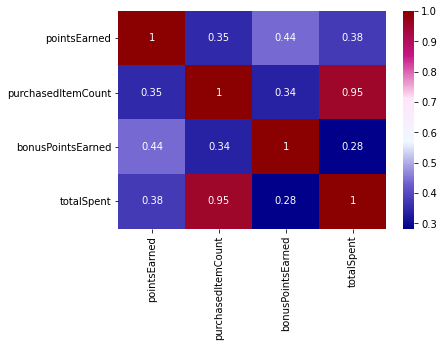

In [37]:
# Check relation between features of receipt data

corrMatrix = df_receipts.corr()
cmap = sns.blend_palette(["#00008B", "#6A5ACD", "#F0F8FF",
                              "#FFE6F8", "#C71585", "#8B0000"], as_cmap=True)
sns.heatmap(corrMatrix, annot=True,cmap=cmap )
plt.show()

#### From the above correlation plot we found that purchasedItemCount and totalSpent have highest correlation. 

### Total PurchasedItem based on RewardsReceiptStatus 

<AxesSubplot:xlabel='rewardsReceiptStatus', ylabel='purchasedItemCount'>

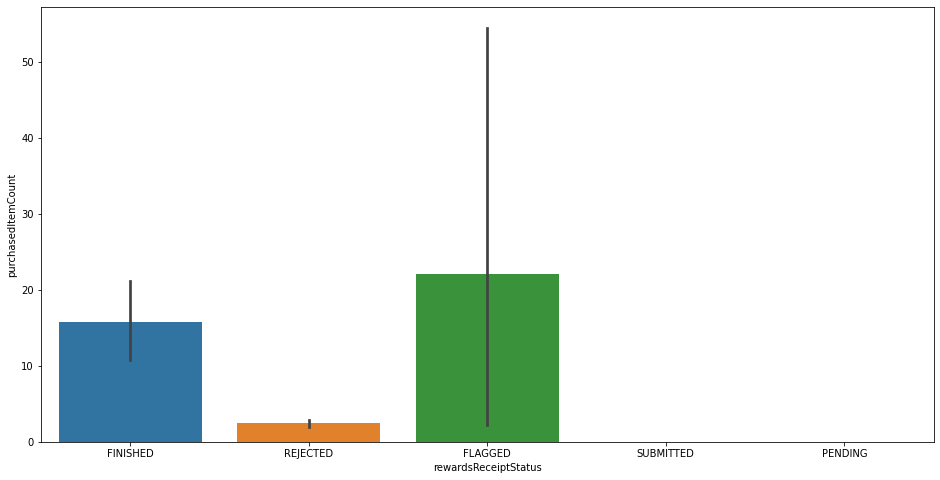

In [38]:
# Graph based on rewardsReceiptStatus

plt.figure(figsize=(16,8))
sns.barplot(x="rewardsReceiptStatus", y="purchasedItemCount",
                 data=df_receipts, linewidth=1)